In [1]:
# Connection to the Vertica Database using ODBC.
import pyodbc
import pandas
import numpy as np
import sys

# Import the Vertica ML Python library 
from vertica_ml_python import RVD
from vertica_ml_python import read_csv # This function will help us to load the csv file in the Database.
from vertica_ml_python import drop_table # This function will help us to drop the unnecessary tables.
from vertica_ml_python import drop_view
from vertica_ml_python import drop_model

cur=pyodbc.connect("DSN=VerticaDSN").cursor()

In [2]:
# If the table is already in the Database. We can create the RVD as follows:
ChangeData=RVD('ChangeData',cur)

In [ ]:
# red csv file to RVD
# Drop table in database if it exists
drop_table("ChangeData",cur)

ChangeData=read_csv('../datasets/ChangeData.csv',cur)

In [3]:
ChangeData.describe()

,count,mean,std,min,25%,50%,75%,max,cardinality
ASSETS,38757,9.13055706066001,44.1922187481697,0.0,1.0,2.0,5.0,3731.0,347
ASSOCIATED_CHANGES,38757,0.00926284284129317,0.127868535033142,0.0,0.0,0.0,0.0,8.0,7
CHILD_CHANGES,38757,0.000541837603529687,0.0317175377952987,0.0,0.0,0.0,0.0,4.0,4
DEPENDENT_CHANGES,38757,0.000851459091260933,0.0308863381656353,0.0,0.0,0.0,0.0,2.0,3
HP_CR_HIGH_THLD_NR,24464,67.1451929365595,12.7728293350562,10.0,70.0,70.0,70.0,70.0,2
HP_CR_SCORE_NR,27872,61.8130022962115,66.0781927564784,0.0,22.0,42.0,75.0,547.0,148
HP_IMPC_ANAL_FND_CT,33677,63.5984499806988,555.077879147999,-51.0,0.0,5.0,28.0,46366.0,1069
IMPACT_ORGS,38757,0.0833655855716392,0.307375106187973,0.0,0.0,0.0,0.0,7.0,8
INCIDENTS,38757,0.310214928916065,0.703288464134569,0.0,0.0,0.0,1.0,46.0,23
INTERACTIONS,38757,0.000154810743865624,0.012441493936754,0.0,0.0,0.0,0.0,1.0,2


<column_matrix>

In [4]:
print(sys.getsizeof(ChangeData))

56


In [5]:
ChangeData.head(5)
ChangeData.dtypes()

,ASSETS,ASSOCIATED_CHANGES,CATEGORY,CHILD_CHANGES,COLLISION_SEVERITY,DEPENDENT_CHANGES,FINANCIAL_IMPACT,GL_NUMBER,HP_CR_HIGH_THLD_NR,HP_CR_SCORE_NR,HP_IMPC_ANAL_FND_CT,IMPACT_ORGS,IMPACT_SEVERITY,INCIDENTS,INTERACTIONS,KNOWNERRORS,MAJOR_INCIDENTS,ML_CHG_IMPC_ASMT_KY,ML_CR_SCORE_RSLT_KY,NUMBER,OVO_OUTAGES,PARENT_CHANGES,PLN_IMP_DURATION,PREDECESSOR_CHANGES,PRIORITY_CODE,PROBLEMS,REQ_IMP_DURATION,RISK_ASSESSMENT,RISK_SEVERITY,SEVERITY,TASKS,TIME_PERIOD_CONFLICT
0,0,0,KM Document,0,None,0,None,None,None,None,None,0,None,0,0,0,0,3,None,C11038046,0,0,604799001.0,0,3,0,0.0,0,None,3,0,None
1,0,0,KM Document,0,None,0,None,None,None,None,None,0,None,0,0,0,0,3,None,C11038048,0,0,604800000.0,0,3,0,0.0,0,None,3,0,None
2,0,0,KM Document,0,None,0,None,None,None,None,None,0,None,0,0,0,0,3,None,C11038095,0,0,604799000.0,0,3,0,0.0,0,None,3,0,None
3,0,0,KM Document,0,None,0,None,None,None,None,None,0,None,0,0,0,0,3,None,C11038193,0,0,604800000.0,0,3,0,0.0,0,None,3,0,None
4,0,0,KM Document,0,None,0,None,None,None,None,None,0,None,0,0,0,0,3,None,C11038198,0,0,604800000.0,0,3,0,0.0,0,None,3,0,None
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Name: ChangeData, Number of rows: 38757, Number of columns: 32


,type
ASSETS,int
ASSOCIATED_CHANGES,int
CATEGORY,varchar(34)
CHILD_CHANGES,int
COLLISION_SEVERITY,varchar(20)
DEPENDENT_CHANGES,int
FINANCIAL_IMPACT,varchar(20)
GL_NUMBER,varchar(20)
HP_CR_HIGH_THLD_NR,int
HP_CR_SCORE_NR,int


Name: ChangeData,Number of rows: 38757,Number of columns: 32


In [6]:
ChangeData.missing()

,total,percent
FINANCIAL_IMPACT,38757,1.0
COLLISION_SEVERITY,36944,0.953
IMPACT_SEVERITY,36944,0.953
RISK_SEVERITY,36944,0.953
TIME_PERIOD_CONFLICT,36944,0.953
SEVERITY,34713,0.896
HP_CR_HIGH_THLD_NR,14293,0.369
HP_CR_SCORE_NR,10885,0.281
ML_CR_SCORE_RSLT_KY,10885,0.281
HP_IMPC_ANAL_FND_CT,5080,0.131


<column_matrix>

The percent above should multiply 100! We can see the first 6 columns have too much of missing values. 
We can drop them from our RVD (the ChangeData table will never be modified: all the actions are only on our RVD).

In [7]:
# drop columns that have too many nulls
ChangeData["FINANCIAL_IMPACT"].drop_column()
ChangeData["COLLISION_SEVERITY"].drop_column()
ChangeData["IMPACT_SEVERITY"].drop_column()
ChangeData["RISK_SEVERITY"].drop_column()
ChangeData["TIME_PERIOD_CONFLICT"].drop_column()
ChangeData["SEVERITY"].drop_column()
ChangeData["GL_NUMBER"].drop_column()

RVC 'FINANCIAL_IMPACT' deleted from the RVD.
RVC 'COLLISION_SEVERITY' deleted from the RVD.
RVC 'IMPACT_SEVERITY' deleted from the RVD.
RVC 'RISK_SEVERITY' deleted from the RVD.
RVC 'TIME_PERIOD_CONFLICT' deleted from the RVD.
RVC 'SEVERITY' deleted from the RVD.
RVC 'GL_NUMBER' deleted from the RVD.


In [8]:
# Fill missing value 
ChangeData["HP_CR_HIGH_THLD_NR"].fillna(val=0) # set missing as 0
ChangeData["HP_CR_SCORE_NR"].fillna(val=0) # set missing as 0
ChangeData["ML_CR_SCORE_RSLT_KY"].fillna(val=0) # set missing as 0
ChangeData["HP_IMPC_ANAL_FND_CT"].fillna(val=0) # set missing as 0

14293 elements were filled
10885 elements were filled
10885 elements were filled
5080 elements were filled


In [9]:
# As the missing number of row is very small, we can delete them
ChangeData["PRIORITY_CODE"].dropna()

9 elements were dropped


In [10]:
# Convert some values using decode method
ChangeData["RISK_ASSESSMENT"].decode(["low","medium", "high","0","10","20", "30"], ["10","20", "30","0","10","20", "30"],"0")

# decode strings to numbers
ChangeData["ML_CHG_IMPC_ASMT_KY"].decode(["0","10","2","20","3","30","40","45","46","47","48",", High - Multiple Domains", "High - Multiple Domains","High - Multiple Domainsd","High - Multiple Domainss","High - Multiple Domainst","High – Multiple Domains","I High - Multiple Domainsd","Medium - One Domaind","Medium – One Domain","cd /Medium - One Domain","medium","application","6ow - One Sub-Domain","LOW","Low - One Sub-Domaina","Low - One Sub-Domainhank","Low - One Sub-Domains","Low - One Sub-Doman","Low – One Sub-Domain","iLow - One Sub-Domaint","inLow - One Sub-Domainp","low"], ["0","10","2","20","3","30","40","45","46","47","48","41","41","41","41","41","41","41","31","31","31","31","31","21","21","21","21","21","21","21","21","21","21"],"0")


In [11]:
# We filter rows where HP_IMPC_ANAL_FND_CT<0
ChangeData.filter("HP_IMPC_ANAL_FND_CT >= 0")

# We filter rows where REQ_IMP_DURATION<0
ChangeData.filter("REQ_IMP_DURATION >= 0")
# We filter rows where REQ_IMP_DURATION<1e10
ChangeData.filter("REQ_IMP_DURATION < 1e10")

# We filter rows where PLN_IMP_DURATION<0
ChangeData.filter("PLN_IMP_DURATION >= 0")
# We filter rows where PLN_IMP_DURATION<1e10
ChangeData.filter("PLN_IMP_DURATION < 1e10")

57 elements were filtered
1 element was filtered
4589 elements were filtered
1 element was filtered
16 elements were filtered


In [ ]:
#We can see the current RVD virtual table.
ChangeData.current_table()

In [ ]:
ChangeData.history()

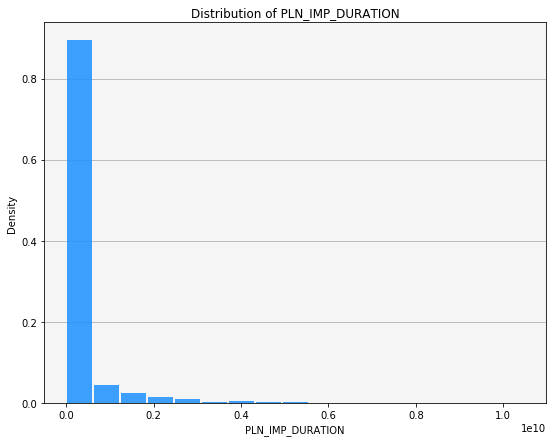

In [12]:
ChangeData['PLN_IMP_DURATION'].hist()

In [13]:
drop_table("random_vpython_table_ChangeData",cur,print_info=False)

In [14]:
# split RVD into a test and a train set.
ChangeData.train_test_split()

The random table random_vpython_table_ChangeData was successfully created.
The views test_ChangeData033 and train_ChangeData067 were successfully created.


,ASSETS,ASSOCIATED_CHANGES,CATEGORY,CHILD_CHANGES,DEPENDENT_CHANGES,HP_CR_HIGH_THLD_NR,HP_CR_SCORE_NR,HP_IMPC_ANAL_FND_CT,IMPACT_ORGS,INCIDENTS,INTERACTIONS,KNOWNERRORS,MAJOR_INCIDENTS,ML_CHG_IMPC_ASMT_KY,ML_CR_SCORE_RSLT_KY,NUMBER,OVO_OUTAGES,PARENT_CHANGES,PLN_IMP_DURATION,PREDECESSOR_CHANGES,PRIORITY_CODE,PROBLEMS,REQ_IMP_DURATION,RISK_ASSESSMENT,TASKS
0,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038046,0,0,604799001.0,0,3,0,0.0,0,0
1,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038048,0,0,604800000.0,0,3,0,0.0,0,0
2,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038095,0,0,604799000.0,0,3,0,0.0,0,0
3,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038310,0,0,604799001.0,0,3,0,0.0,0,0
4,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038376,0,0,604800000.0,0,3,0,0.0,0,0
5,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038426,0,0,604799001.0,0,3,0,0.0,0,0
6,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038450,0,0,604799000.0,0,3,0,0.0,0,0
7,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038502,0,0,604800000.0,0,3,0,0.0,0,0
8,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038503,0,0,604800000.0,0,3,0,0.0,0,0
9,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038505,0,0,604800000.0,0,3,0,0.0,0,0


,ASSETS,ASSOCIATED_CHANGES,CATEGORY,CHILD_CHANGES,DEPENDENT_CHANGES,HP_CR_HIGH_THLD_NR,HP_CR_SCORE_NR,HP_IMPC_ANAL_FND_CT,IMPACT_ORGS,INCIDENTS,INTERACTIONS,KNOWNERRORS,MAJOR_INCIDENTS,ML_CHG_IMPC_ASMT_KY,ML_CR_SCORE_RSLT_KY,NUMBER,OVO_OUTAGES,PARENT_CHANGES,PLN_IMP_DURATION,PREDECESSOR_CHANGES,PRIORITY_CODE,PROBLEMS,REQ_IMP_DURATION,RISK_ASSESSMENT,TASKS
0,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038193,0,0,604800000.0,0,3,0,0.0,0,0
1,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038198,0,0,604800000.0,0,3,0,0.0,0,0
2,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038199,0,0,604800000.0,0,3,0,0.0,0,0
3,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038254,0,0,604800000.0,0,3,0,0.0,0,0
4,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038385,0,0,604800000.0,0,3,0,0.0,0,0
5,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038398,0,0,604799000.0,0,3,0,0.0,0,0
6,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038501,0,0,604798999.0,0,3,0,0.0,0,0
7,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038504,0,0,604799000.0,0,3,0,0.0,0,0
8,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038564,0,0,604800000.0,0,3,0,0.0,0,0
9,0,0,KM Document,0,0,0,0,0,0,0,0,0,0,3,0,C11038602,0,0,604800000.0,0,3,0,0.0,0,0


(Name: train_ChangeData067, Number of rows: 22845, Number of columns: 25,
 Name: test_ChangeData033, Number of rows: 11239, Number of columns: 25)

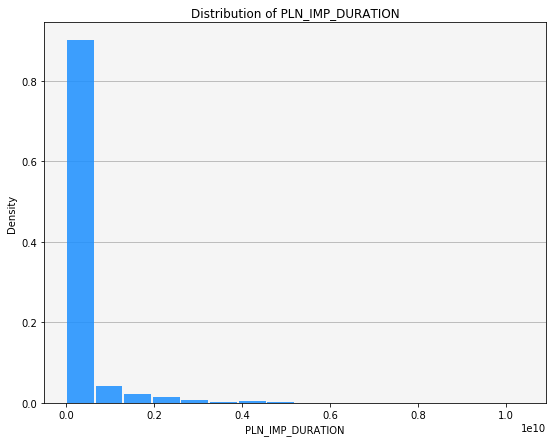

In [15]:
ChangeData_train=RVD('train_ChangeData067',cur)

ChangeData_train['PLN_IMP_DURATION'].hist()

# Random Forest

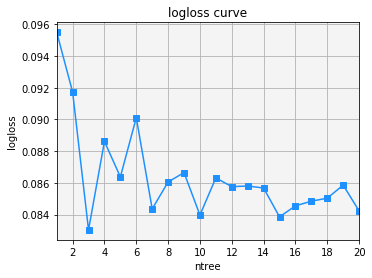

In [16]:
# Before building our RF model, let's see the logloss according to the number of trees.
from vertica_ml_python import metric_rf_curve_ntree
logloss_curve=metric_rf_curve_ntree(input_relation='train_ChangeData067',test_relation='test_ChangeData033',response_column='RISK_ASSESSMENT',
                                     predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,test_only=True,
                                     ntree_begin=1,ntree_end=20)

In [ ]:
logloss_curve

In [17]:
import numpy

# Thanks to this curve, we can see that the ideal number of trees seems to be around {{best_ntree}}. 
# This information can be very useful when the dataset is huge. We have to remember that trees are huge victims of overfitting, 
# that's why we need to be careful and to always analyse the test set, i.e. logloss_curve[0]. We are now ready to build the RF model.

best_ntree=numpy.argmin(logloss_curve[0].data_columns[1][1:-1])+1

print(best_ntree)

3


In [18]:
from vertica_ml_python import rf_classifier
from vertica_ml_python import drop_model
from vertica_ml_python import load_model

drop_model("rf_ChangeData",cur)
rf=rf_classifier(model_name="rf_ChangeData",input_relation="train_ChangeData067",response_column="RISK_ASSESSMENT",
                    predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,ntree=best_ntree)

The model rf_ChangeData was successfully dropped.


In [20]:
print(rf)

column,type
predecessor_changes,int
priority_code,int
problems,int
req_imp_duration,float
tasks,int
category,char or varchar
assets,int
associated_changes,int
child_changes,int
dependent_changes,int


model_type='rf_classifier'
model_name='rf_ChangeData'
input_relation='train_ChangeData067'
response_column='RISK_ASSESSMENT'
predictor_columns='PREDECESSOR_CHANGES,PRIORITY_CODE,PROBLEMS,REQ_IMP_DURATION,TASKS,CATEGORY,ASSETS,ASSOCIATED_CHANGES,CHILD_CHANGES,DEPENDENT_CHANGES,HP_CR_HIGH_THLD_NR,HP_CR_SCORE_NR,HP_IMPC_ANAL_FND_CT,IMPACT_ORGS,INCIDENTS,INTERACTIONS,KNOWNERRORS,MAJOR_INCIDENTS,ML_CR_SCORE_RSLT_KY,OVO_OUTAGES,PARENT_CHANGES,PLN_IMP_DURATION'
tree_count: 3
rejected_row_count: 0
accepted_row_count: 22862


In [19]:
rf.accuracy(threshold =0.5 , input_class = None )

0.842197417377982

In [20]:
rf.auc(input_class = None )

0.9207456094677352

In [21]:
rf.confusion_matrix (threshold =0.5 , input_class = None )

,0,10,20,30
0,2729,384,15,0
10,0,15127,282,0
20,0,2401,1384,0
30,0,302,221,0


<column_matrix>

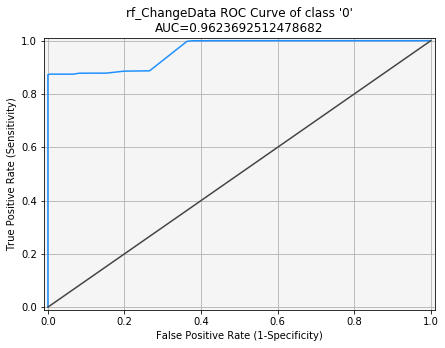

In [22]:
roc=rf.roc()

In [23]:
auc=rf.auc()
best_threshold=roc[0].data_columns[1][2]
print(best_threshold)

0.17


In [24]:
roc

,value
auc,0.9623692512478682
best_threshold,0.17


,threshold,false_positive,true_positive
0,0.0,1.0,1.0
1,0.01,0.999949282345184,1.0
2,0.02,0.996500481817721,1.0
3,0.03,0.459755540903789,1.0
4,0.04,0.421666582137242,1.0
5,0.05,0.420347923112035,0.999680306905371
6,0.06,0.419435005325354,0.999680306905371
7,0.07,0.378810163818025,0.999680306905371
8,0.08,0.363442714408886,0.997762148337596
9,0.09,0.265608358269514,0.886828644501279


(<column_matrix>, <column_matrix>)

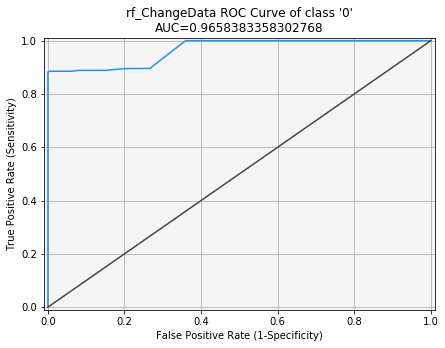

,error_rate
0,0.117528542646071
10,0.0203655352480418
20,0.646121147715197
30,1.0
total,0.156152682623009


<column_matrix>

In [25]:
# Apply to test data
from vertica_ml_python import load_model
rf_test=load_model("rf_ChangeData",cur,input_relation="test_ChangeData033")
rf_test.roc()
rf_test.error_rate()

In [26]:
ChangeData_test=RVD('test_ChangeData033',cur)
name=rf_test.add_to_rvd(ChangeData_test)
ChangeData_test.add_feature('prediction_val',ChangeData_test[name].transformations[0][0]+'=RISK_ASSESSMENT')
ChangeData_test.filter('prediction_val=False')
ChangeData_test["RISK_ASSESSMENT"].convert_to_num()

The new RVC 'rf_classifier_pred1423' was added to the RVD.
The new RVC 'prediction_val' was added to the RVD.
9484 elements were filtered


# try to use rf function to generate single tree

In [27]:
rf_1=rf_classifier(model_name="rf_ChangeData_1",input_relation="train_ChangeData067",response_column="RISK_ASSESSMENT",
                    predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,ntree=1)

In [33]:
rf_1.accuracy(threshold =0.5 , input_class = None )

0.8472313416502519

In [36]:
rf_1.auc(input_class = None )

0.9304716665693269

In [35]:
rf_1.confusion_matrix (threshold =0.5 , input_class = None )

,0,10,20,30
0,2729,380,19,0
10,0,14970,439,0
20,0,2129,1656,0
30,0,296,227,0


<column_matrix>

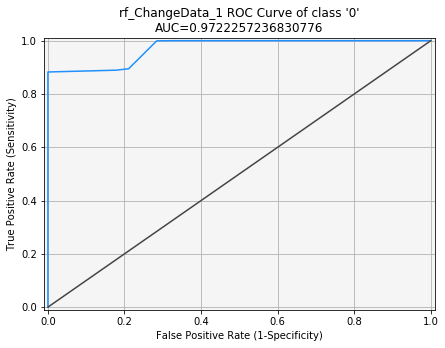

,error_rate
0,0.117528542646071
10,0.0317232375979112
20,0.568544102019129
30,1.0
total,0.150903105258475


<column_matrix>

In [39]:
# Apply to test data
rf1_test=load_model("rf_ChangeData_1",cur,input_relation="test_ChangeData033")
rf1_test.roc()
rf1_test.error_rate()

In [40]:
rf1_test.confusion_matrix (threshold =0.5 , input_class = None )

,0,10,20,30
0,1314,166,9,0
10,0,7417,243,0
20,0,1070,812,0
30,0,119,89,0


<column_matrix>

# Display random forest decision tree

In [42]:
def display_tree(conn,model_name,tree_id=0):
    query=("select read_tree(using parameters model_name='{}', tree_id='{}')")
    query=query.format(model_name,tree_id)
    tree=pandas.read_sql(query,conn)
    print(tree['tree_digraph'][0])
    
    import csv
    import pydotplus 
    import graphviz
    from IPython.display import Image  
    model_tree=model_name+"_tree_"+str(tree_id)+".dot"    
    tree['tree_digraph'].to_frame().to_csv(model_tree,encoding='utf-8',header=False,index=False,quoting=csv.QUOTE_NONE, escapechar=' ')
    graph = pydotplus.graphviz.graph_from_dot_file(model_tree)
    
    return Image(graph.create_png()) 

digraph Tree{
1 [label = "hp_cr_high_thld_nr < 2.187500 ?", color="blue"];
1 -> 2 [label = "yes", color = "black"];
1 -> 3 [label = "no", color = "black"];
2 [label = "req_imp_duration < 297000000.000000 ?", color="blue"];
2 -> 4 [label = "yes", color = "black"];
2 -> 5 [label = "no", color = "black"];
4 [label = "priority_code < 2.031250 ?", color="blue"];
4 -> 8 [label = "yes", color = "black"];
4 -> 9 [label = "no", color = "black"];
8 [label = "tasks < 8.250000 ?", color="blue"];
8 -> 16 [label = "yes", color = "black"];
8 -> 17 [label = "no", color = "black"];
16 [label = "ml_cr_score_rslt_ky < 0.937500 ?", color="blue"];
16 -> 32 [label = "yes", color = "black"];
16 -> 33 [label = "no", color = "black"];
32 [label = "prediction: 10, probability: 0.881493", color="red"];
33 [label = "prediction: 10, probability: 0.698925", color="red"];
17 [label = "category == Routine Changes ?", color="blue"];
17 -> 34 [label = "yes", color = "black"];
17 -> 35 [label = "no", color = "black"];
3

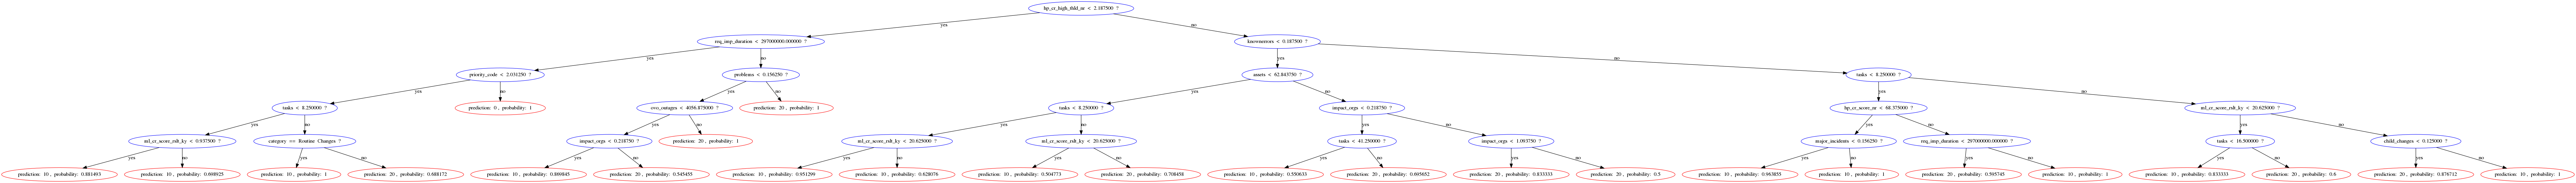

In [43]:
conn=pyodbc.connect("DSN=VerticaDSN")
# tree 0 of random forest 
display_tree(conn,'rf_ChangeData',0)

digraph Tree{
1 [label = "category == KM Document ?", color="blue"];
1 -> 2 [label = "yes", color = "black"];
1 -> 3 [label = "no", color = "black"];
2 [label = "prediction: 0, probability: 1", color="red"];
3 [label = "tasks < 8.250000 ?", color="blue"];
3 -> 6 [label = "yes", color = "black"];
3 -> 7 [label = "no", color = "black"];
6 [label = "ml_cr_score_rslt_ky < 20.625000 ?", color="blue"];
6 -> 12 [label = "yes", color = "black"];
6 -> 13 [label = "no", color = "black"];
12 [label = "category == Routine Changes ?", color="blue"];
12 -> 24 [label = "yes", color = "black"];
12 -> 25 [label = "no", color = "black"];
24 [label = "prediction: 10, probability: 1", color="red"];
25 [label = "hp_cr_high_thld_nr < 2.187500 ?", color="blue"];
25 -> 50 [label = "yes", color = "black"];
25 -> 51 [label = "no", color = "black"];
50 [label = "prediction: 10, probability: 0.644128", color="red"];
51 [label = "prediction: 10, probability: 0.946086", color="red"];
13 [label = "hp_cr_score_nr < 6

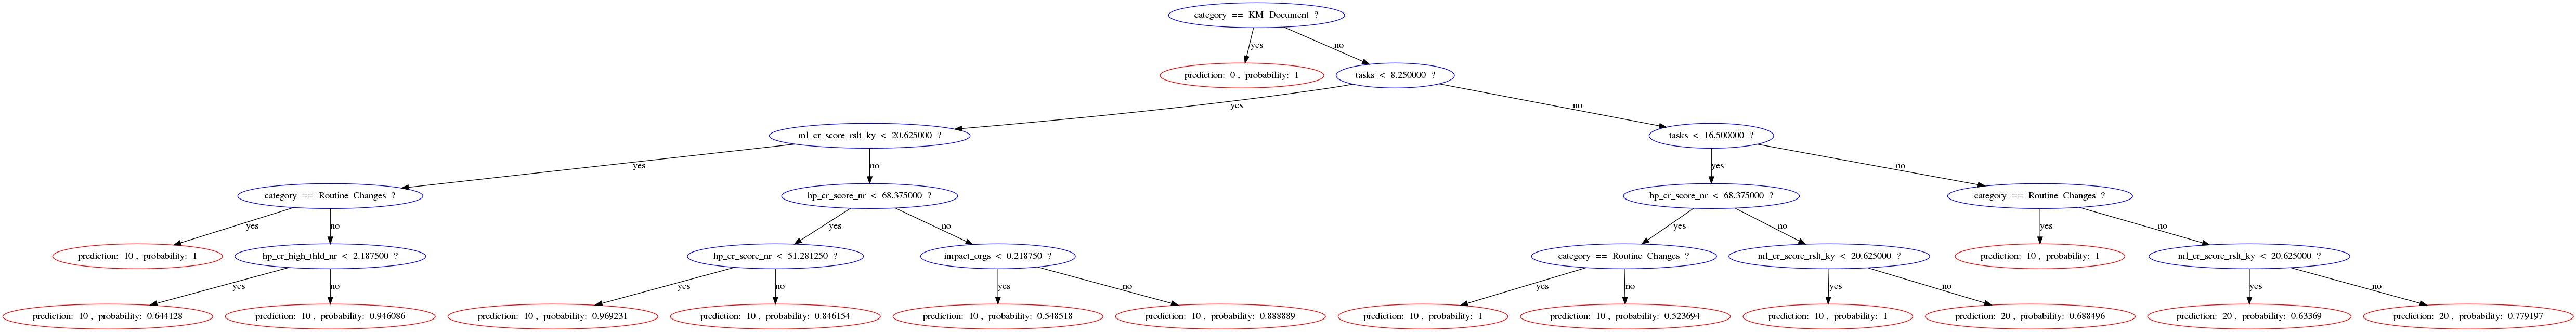

In [44]:
# single tree 
display_tree(conn,'rf_ChangeData_1',0)

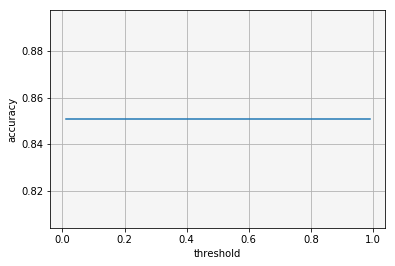

In [29]:
import math
import matplotlib.pyplot as plt

all_accuracy=[]
all_threshold=[]
for i in range(1,100):
    threshold=float(i/100)
    all_threshold+=[threshold]
    all_accuracy+=[rf_test.accuracy(threshold=threshold)]

plt.grid()
plt.plot(all_threshold,all_accuracy)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

### <font color='#555555'>Comparing metrics to scikit-learn [Random Forest]<font>
Let's compare again Vertica to scikit learn but this time with the random forest classifier.

In [45]:
# In order to use scikit random forest, we need some data preparation as the model does not accept non-numerical values and missing values (it can be very painful to do all these modifications).
ChangeData.dtypes()

,type
ASSETS,int
ASSOCIATED_CHANGES,int
CATEGORY,varchar(34)
CHILD_CHANGES,int
DEPENDENT_CHANGES,int
HP_CR_HIGH_THLD_NR,float
HP_CR_SCORE_NR,float
HP_IMPC_ANAL_FND_CT,float
IMPACT_ORGS,int
INCIDENTS,int


Name: ChangeData,Number of rows: 34084,Number of columns: 25


In [46]:
ChangeData["CATEGORY"].label_encode()

CATEGORY,encoding
KM Document,0
Emergency Changes,1
Routine Changes,2
Normal Changes,3


The label encoding was successfully done.


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

#conn=pyodbc.connect("DSN=VerticaDSN")

number_rounds=5
vertica_accuracy=[]
vertica_auc=[]
scikit_accuracy=[]
scikit_auc=[]
for i in range(number_rounds):
    # Split the data into two views
    drop_table("random_vpython_table_ChangeData",cur,print_info=False)
    ChangeData.train_test_split(print_info=False)
    
    # Scikit
    ChangeData_df_train=pandas.read_sql("select * from train_ChangeData067",conn)
    ChangeData_df_test=pandas.read_sql("select * from test_ChangeData033",conn)
    model=RandomForestClassifier(n_estimators=20,max_features=5,max_depth=5)
    model.fit(ChangeData_df_train[["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"]],ChangeData_df_train["RISK_ASSESSMENT"])
    # accuracy
    predicted=model.predict(ChangeData_df_test[["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"]])
    scikit_accuracy+=[accuracy_score(predicted,ChangeData_df_test["RISK_ASSESSMENT"])]
    # auc
    response=model.predict_proba(ChangeData_df_test[["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"]])
    #scikit_auc+=[roc_auc_score([int(item) for item in ChangeData_df_test["RISK_ASSESSMENT"].tolist()],[item[1] for item in response])]
    
    # Vertica
    drop_model("rf_ChangeData_20",cur,print_info=False)
    rf=rf_classifier(model_name="rf_ChangeData_20",input_relation="train_ChangeData067",response_column="RISK_ASSESSMENT",
                    predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,ntree=20,
                    mtry=5,max_depth=5,sampling_size=1.0)
    rf_test=load_model("rf_ChangeData_20",cur,input_relation="test_ChangeData033")
    # accuracy
    vertica_accuracy+=[rf_test.accuracy()]
    # auc
    vertica_auc+=[rf_test.auc()] 

/!\ Warning: The model rf_ChangeData_20 doesn't exist !


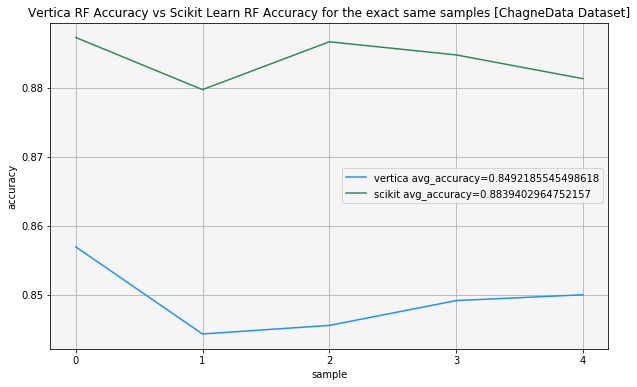

In [48]:
# Let's now compare the different accuracies...

from matplotlib import pyplot as plt
import numpy
sample=list(range(number_rounds))

# accuracy
plt.figure(figsize=(10,6))
plt.plot(sample,vertica_accuracy,label="vertica avg_accuracy="+str(numpy.mean(vertica_accuracy)),color="dodgerblue")
plt.plot(sample,scikit_accuracy,label="scikit avg_accuracy="+str(numpy.mean(scikit_accuracy)),color="seagreen")
plt.ylabel('accuracy')
plt.xlabel('sample')
plt.legend()
plt.grid()
plt.xticks(sample,sample)
plt.title('Vertica RF Accuracy vs Scikit Learn RF Accuracy for the exact same samples [ChagneData Dataset]')
plt.show()

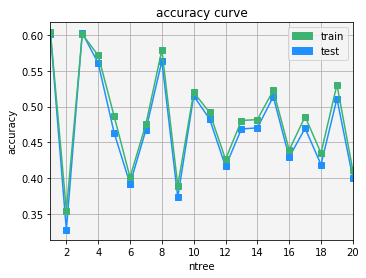

In [51]:
# evaluate accurancy vs. number of trees
from vertica_ml_python import metric_rf_curve_depth
accuracy_curve=metric_rf_curve_ntree(input_relation='train_ChangeData067',test_relation='test_ChangeData033',response_column="RISK_ASSESSMENT",
                    predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,mode='accuracy',ntree_begin=1,ntree_end=20,
                                     max_breadth=1000,test_only=False,sampling_size=1.0)

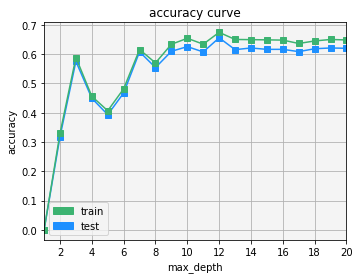

In [49]:
# evaluate accurancy vs. depth of trees
from vertica_ml_python import metric_rf_curve_depth
accuracy_curve=metric_rf_curve_depth(input_relation='train_ChangeData067',test_relation='test_ChangeData033',response_column="RISK_ASSESSMENT",
                    predictor_columns=["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"],cursor=cur,mode='accuracy',max_depth_begin=1,max_depth_end=20,
                                    max_breadth=1000,test_only=False,sampling_size=1.0)

In [56]:
# show feature importanes from scikit 
feature_names = ["PREDECESSOR_CHANGES","PRIORITY_CODE","PROBLEMS","REQ_IMP_DURATION","TASKS",
                     "CATEGORY","ASSETS","ASSOCIATED_CHANGES","CHILD_CHANGES","DEPENDENT_CHANGES",
                     "HP_CR_HIGH_THLD_NR","HP_CR_SCORE_NR","HP_IMPC_ANAL_FND_CT","IMPACT_ORGS","INCIDENTS","INTERACTIONS",
                     "KNOWNERRORS","MAJOR_INCIDENTS","ML_CR_SCORE_RSLT_KY","OVO_OUTAGES","PARENT_CHANGES",
                     "PLN_IMP_DURATION"]
print("Feature names:\n{}".format(feature_names))
print("Feature importances:\n{}".format(model.feature_importances_))

Feature names:
['PREDECESSOR_CHANGES', 'PRIORITY_CODE', 'PROBLEMS', 'REQ_IMP_DURATION', 'TASKS', 'CATEGORY', 'ASSETS', 'ASSOCIATED_CHANGES', 'CHILD_CHANGES', 'DEPENDENT_CHANGES', 'HP_CR_HIGH_THLD_NR', 'HP_CR_SCORE_NR', 'HP_IMPC_ANAL_FND_CT', 'IMPACT_ORGS', 'INCIDENTS', 'INTERACTIONS', 'KNOWNERRORS', 'MAJOR_INCIDENTS', 'ML_CR_SCORE_RSLT_KY', 'OVO_OUTAGES', 'PARENT_CHANGES', 'PLN_IMP_DURATION']
Feature importances:
[6.31120126e-05 1.97146840e-01 4.12833582e-04 1.26584803e-01
 1.55917522e-01 4.24152217e-02 1.32646268e-01 5.75742406e-04
 0.00000000e+00 9.57997424e-05 1.26642102e-02 6.22958020e-02
 1.23401359e-02 1.48132007e-03 1.79947678e-03 0.00000000e+00
 2.69108912e-04 1.28888684e-04 3.91539666e-02 1.68719136e-01
 0.00000000e+00 4.52898125e-02]


In [158]:
# visualize the importance

def plot_feature_importances(model,feature_name):   
    n_features = len(feature_name)  
    ids = model.feature_importances_.argsort()
    plt.barh(range(n_features), model.feature_importances_[ids], align='center')  
    sorted_names =[]
    for i in ids: 
        sorted_names.append(feature_names[i])
    plt.yticks(range(n_features), sorted_names)     
    plt.xlabel("Feature importance")    
    plt.ylabel("Feature")
    
    
    print(sorted_names[::-1],model.feature_importances_[ids[::-1]])
    return sorted_names[::-1]

['PRIORITY_CODE', 'OVO_OUTAGES', 'TASKS', 'ASSETS', 'REQ_IMP_DURATION', 'HP_CR_SCORE_NR', 'PLN_IMP_DURATION', 'CATEGORY', 'ML_CR_SCORE_RSLT_KY', 'HP_CR_HIGH_THLD_NR', 'HP_IMPC_ANAL_FND_CT', 'INCIDENTS', 'IMPACT_ORGS', 'ASSOCIATED_CHANGES', 'PROBLEMS', 'KNOWNERRORS', 'MAJOR_INCIDENTS', 'DEPENDENT_CHANGES', 'PREDECESSOR_CHANGES', 'PARENT_CHANGES', 'CHILD_CHANGES', 'INTERACTIONS'] [1.97146840e-01 1.68719136e-01 1.55917522e-01 1.32646268e-01
 1.26584803e-01 6.22958020e-02 4.52898125e-02 4.24152217e-02
 3.91539666e-02 1.26642102e-02 1.23401359e-02 1.79947678e-03
 1.48132007e-03 5.75742406e-04 4.12833582e-04 2.69108912e-04
 1.28888684e-04 9.57997424e-05 6.31120126e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


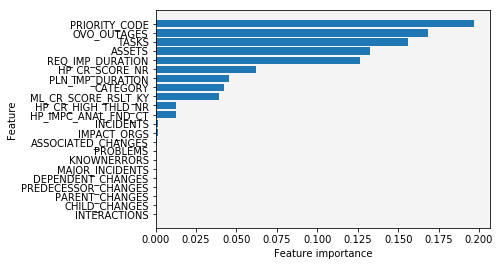

In [159]:
sorted_features = plot_feature_importances(model,feature_names)

In [161]:
print (sorted_features[:11])

['PRIORITY_CODE', 'OVO_OUTAGES', 'TASKS', 'ASSETS', 'REQ_IMP_DURATION', 'HP_CR_SCORE_NR', 'PLN_IMP_DURATION', 'CATEGORY', 'ML_CR_SCORE_RSLT_KY', 'HP_CR_HIGH_THLD_NR', 'HP_IMPC_ANAL_FND_CT']


In [162]:
# only use a few most important features for single tree
final_tree=rf_classifier(model_name="rf_ChangeData_final",input_relation="train_ChangeData067",response_column="RISK_ASSESSMENT",
                    predictor_columns=sorted_features[:11],cursor=cur,ntree=1)


In [163]:
final_tree.accuracy(threshold =0.5 , input_class = None )

0.834711840417533

In [164]:
final_tree.auc(input_class = None )

0.8702391652856543

In [165]:
final_tree.confusion_matrix (threshold =0.5 , input_class = None )

,0,10,20,30
0,2674,363,7,0
10,0,15092,261,0
20,0,2639,1094,5
30,0,307,155,12


<column_matrix>

digraph Tree{
1 [label = "hp_cr_score_nr < 68.375000 ?", color="blue"];
1 -> 2 [label = "yes", color = "black"];
1 -> 3 [label = "no", color = "black"];
2 [label = "priority_code < 2.031250 ?", color="blue"];
2 -> 4 [label = "yes", color = "black"];
2 -> 5 [label = "no", color = "black"];
4 [label = "hp_cr_score_nr < 51.281250 ?", color="blue"];
4 -> 8 [label = "yes", color = "black"];
4 -> 9 [label = "no", color = "black"];
8 [label = "assets < 62.843750 ?", color="blue"];
8 -> 16 [label = "yes", color = "black"];
8 -> 17 [label = "no", color = "black"];
16 [label = "category < 2.062500 ?", color="blue"];
16 -> 32 [label = "yes", color = "black"];
16 -> 33 [label = "no", color = "black"];
32 [label = "prediction: 10, probability: 0.96518", color="red"];
33 [label = "prediction: 10, probability: 0.820975", color="red"];
17 [label = "req_imp_duration < 304987500.000000 ?", color="blue"];
17 -> 34 [label = "yes", color = "black"];
17 -> 35 [label = "no", color = "black"];
34 [label = "pr

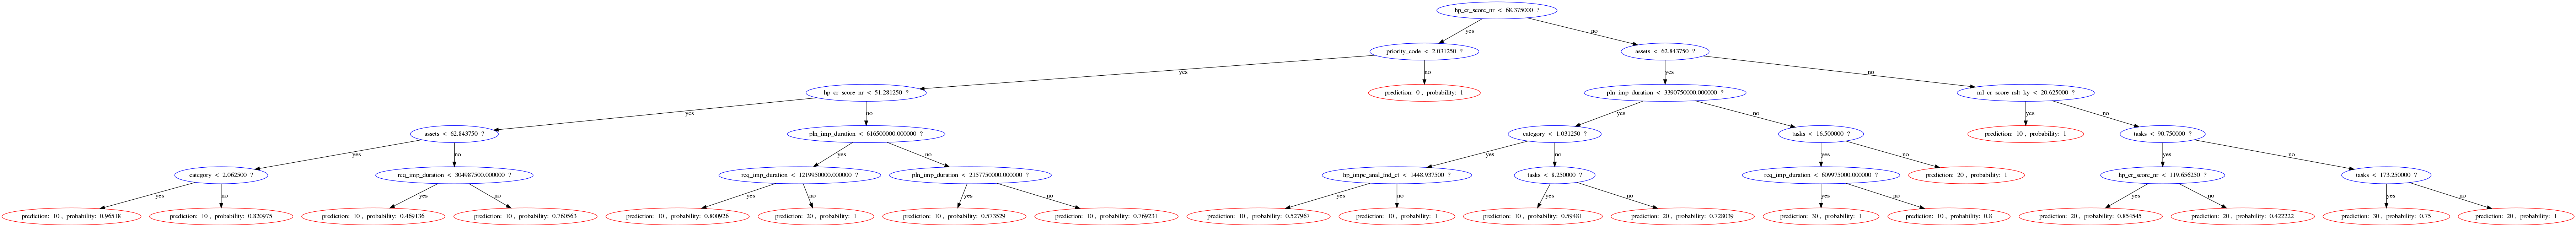

In [166]:
# single tree 
display_tree(conn,'rf_ChangeData_final',0)